# HMMやらを使ってやってみる

## 結論

acc: 84%<br>
おや？精度的にはよくない...

フィルタかけて<br>
acc: 91%<br>
But, ラベルがわがよくなかった説が濃厚


In [1]:
!pip install --user git+https://github.com/hmmlearn/hmmlearn

  Cloning https://github.com/hmmlearn/hmmlearn to /tmp/pip-req-build-y3beb995
  Running command git clone -q https://github.com/hmmlearn/hmmlearn /tmp/pip-req-build-y3beb995
  Created wheel for hmmlearn: filename=hmmlearn-0.2.3.post4+g70f6194-cp37-cp37m-linux_x86_64.whl size=338698 sha256=052735ef8a67019290322e215bc82cb179fe9b3602e516472747cafcbeb41645
  Stored in directory: /tmp/pip-ephem-wheel-cache-igvh121b/wheels/7f/cc/98/d190f4447289e337cb2ea7b7eb1bf85a8c8707f6db73639484
Successfully built hmmlearn


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
import pandas as pd
from scipy.stats import norm
csv = pd.read_csv('西山貧乏ゆすりデータ.csv')
x, y, z, out = csv[['X', 'Y', 'Z', 'Out']].values.T

In [2]:
def slide(data, f, width=5) :
    dist = []
    pad_data = np.pad(data, (0, width-1), 'mean')
    for i, _ in enumerate(data):
        dist.append(f(pad_data[i:i+width]))
    dist = np.array(dist)
    return dist
def binarization(data, threshold):
    dist = data.copy()
    dist[data < threshold]  = 0.
    dist[data >= threshold] = 1.
    return dist
def get_leg_vibration(x, y):
    """
    貧乏ゆすりを検出する(精度: 91%程度)
    
    param: 
        x: ndarray型で加速度センサXの取得
        y: ndarray型で加速度センサYの取得
    return: 
        ndarray型で1なら貧乏ゆすり、0ならそれ以外
    """
    mean_xy = np.mean([x, y], axis=0)
    slide_var_xy = slide(mean_xy,lambda x:x.var(),width=33)
    return binarization(slide_var_xy, 0.024)

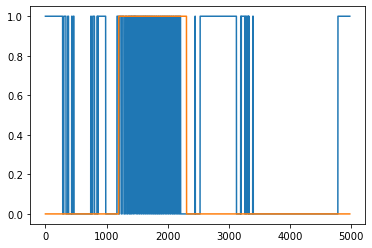

In [3]:
mean_xy = np.mean([x, y], axis=0)
model = hmm.GaussianHMM(n_components=2)
model.fit( mean_xy.reshape(-1, 1) )
L,Z = model.decode( mean_xy.reshape(-1, 1) )
plt.plot( Z )
plt.plot( out )

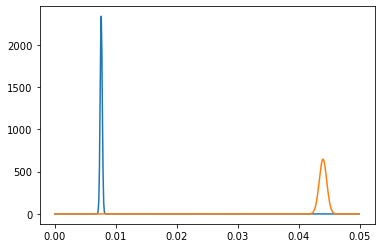

In [4]:
mean_xy = np.mean([x, y], axis=0)
slide_var_xy = slide(mean_xy,lambda x:x.var(),width=33)

norm_x = np.arange(0,0.05,0.0001)
norm_y = norm.pdf(norm_x, slide_var_xy[out == 0].mean(), slide_var_xy[out == 0].var())
plt.plot(norm_x, norm_y)

norm_x = np.arange(0,0.05,0.0001)
norm_y = norm.pdf(norm_x, slide_var_xy[out == 1].mean(), slide_var_xy[out == 1].var())
plt.plot(norm_x, norm_y)

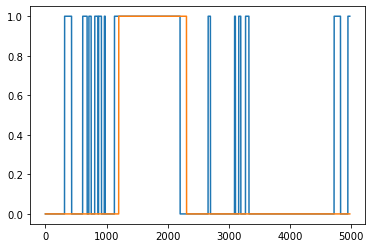

In [5]:
model = hmm.GaussianHMM(n_components=2, covariance_type='spherical')
model.startprob_ = np.array([0., 1.])
model.means_ = np.array([
    slide_var_xy[out == 0].mean(),
    slide_var_xy[out == 1].mean(),
])
# このパラメータの入れ方自信ない...
model.covars_ = np.array([
    slide_var_xy[out == 0].var(),
    slide_var_xy[out == 1].var()
])
model.fit( slide_var_xy.reshape(-1, 1) )
L,Z = model.decode( slide_var_xy.reshape(-1, 1) )
plt.plot( Z )
plt.plot( out )

In [6]:
print('acc:', (model.predict(slide_var_xy.reshape(-1, 1))==out).sum() / slide_var_xy.shape[0] )

acc: 0.8404020100502513


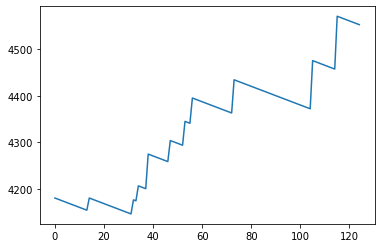

In [7]:
dist = model.predict(slide_var_xy.reshape(-1, 1))
def noiseRemover(data, n):
    w = data.copy()
    for i in range(n):
        w = slide(w, lambda x: 0 if x[0]==1 and x[1]==0 or x[0]==0 and x[1]==1 else x[0] , width=2)
    for i in range(n):
        w = slide(w, lambda x: 1 if x[0]==1 and x[1]==0 or x[0]==0 and x[1]==1 else x[0] , width=2)
    return w
n = []
for i in range(125):
    n.append( (noiseRemover(dist, i)==out).sum() ) 
plt.plot(n)

In [8]:
n_max = np.argmax(n)
print('max noize filter n 1番目:', n_max, ', acc:', np.max(n) / out.shape[0] )

max noize filter n 1番目: 115 , acc: 0.9185929648241206


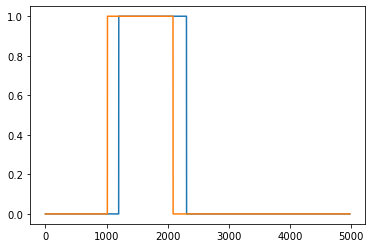

In [9]:
plt.plot( out )
plt.plot( noiseRemover(dist, n_max) )
plt.show()

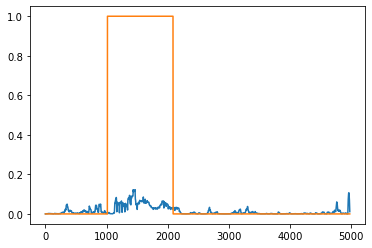

In [10]:
plt.plot( slide_var_xy )
plt.plot( noiseRemover(dist, n_max) )